In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

from energymodel import (
    EnergyModel, EMSolver, random_uniform, NanMonitor, Lyapunov
)

tf.compat.v1.reset_default_graph()

## Dataset

In [2]:
def remap(x):
    """Re-map the x to the range [-1, 1]."""
    return tf.where(
        x < -1,
        -x - 2,
        tf.where(
            x > 1,
            -x + 2,
            x))

def vector_field(z):
    x = z[:, 0][:, tf.newaxis]
    l = z[:, 1][:, tf.newaxis]

    l = -0.5 - remap(l + 0.5)

    dx = l * x + 2 * x**2 - x**3
    dl = tf.zeros_like(l)

    return tf.concat([dx, dl], axis=1)

def resample(batch_size):
    # x in (-0.5, 1.5)
    # x = 0.5 + random_uniform([batch_size, 1])
    # x in (-1, 3)
    x = 1 + 2 * random_uniform([batch_size, 1])
    # l in (-1.5, 0.5)
    l = -0.5 + random_uniform([batch_size, 1])
    return tf.concat([x, l], axis=1)


batch_size = 128
solver = EMSolver(dt=1e-1, eps=1e-2)

lyapunov = Lyapunov(
    vector_field,
    resample,
    solver,
    5e-0,
    T=1e-2,
    batch_size=batch_size,
)

## Model

In [3]:
network = models.Sequential([
    layers.Dense(256),
    layers.Activation('swish'),

    layers.Dense(64),
    layers.Activation('swish'),

    layers.Dense(1, use_bias=False),
])
network(resample(batch_size))  # build.

model = EnergyModel(
    network,
    resample,
    solver,
    5e-0,
)
tf.print('T =', model.T)

optimizer = tf.keras.optimizers.Adam(1e-3, clipvalue=1e-1)
callbacks = [
    NanMonitor(5),
]

train_step = model.get_optimize_fn(optimizer, callbacks)
train_step = tf.function(train_step)

T = 0.0119639011


In [4]:
def criterion(test_batch):
    return tf.reduce_sum(model.vector_field(test_batch) * vector_field(test_batch), axis=1)

test_batch = resample(batch_size)

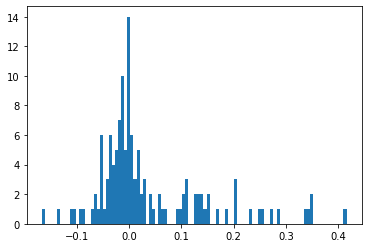

In [5]:
Y = criterion(test_batch)
plt.hist(Y.numpy(), bins=100)
plt.show()

In [6]:
for step in tqdm(range(2000)):
    batch = lyapunov()
    train_step(batch)

100%|██████████| 2000/2000 [02:41<00:00, 12.37it/s]


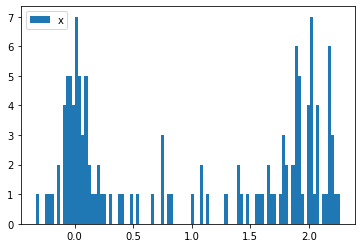

In [7]:
plt.hist(lyapunov().numpy()[:, 0], bins=100, label='x')
plt.legend()
plt.show()

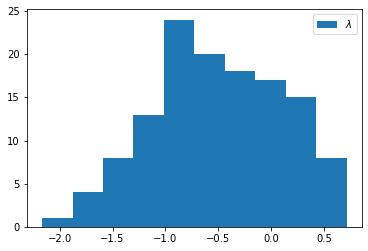

In [8]:
plt.hist(lyapunov().numpy()[:, 1], label='$\lambda$')
plt.legend()
plt.show()

## Evaluation

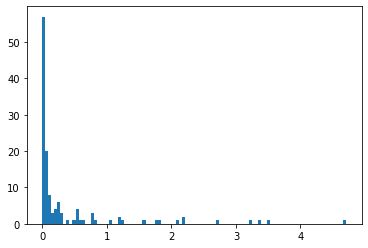

-0.005758485


In [9]:
Y2 = criterion(test_batch)
plt.hist(Y2.numpy(), bins=100)
plt.show()
print(Y2.numpy().min())

## Visualization

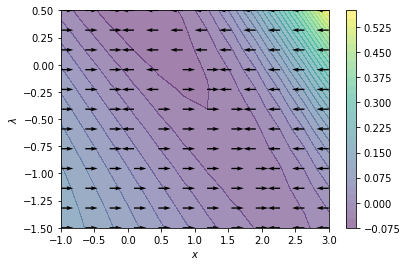

In [48]:
num_grids = 12
plot_X, plot_Y = np.meshgrid(
    np.linspace(-1, 3, num_grids),
    np.linspace(-1.5, 0.5, num_grids),
)
plot_batch = np.concatenate(
    [plot_X.reshape([-1, 1]), plot_Y.reshape([-1, 1])],
    axis=1
)
E = -network(plot_batch).numpy().reshape(num_grids, num_grids)
plt.contourf(plot_X, plot_Y, E, 30, alpha=0.5)
plt.colorbar()

vec = vector_field(plot_batch).numpy().reshape(num_grids, num_grids, 2)
vec = np.sign(vec)
vec_X, vec_Y = vec[:, :, 0], vec[:, :, 1]
plt.quiver(plot_X, plot_Y, vec_X, vec_Y)

plt.xlabel('$x$')
plt.ylabel('$\lambda$')
plt.show()

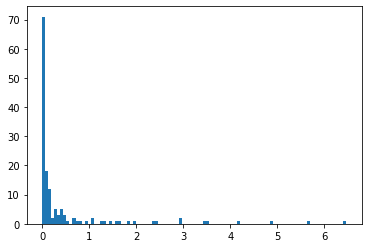

-0.00832038688467105


In [49]:
plot_Y = criterion(tf.convert_to_tensor(plot_batch))
plt.hist(plot_Y.numpy(), bins=100)
plt.show()

print(plot_Y.numpy().min())